In [337]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import math
import sys
from math import log
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from generate_data import *
from train_models import *
from honest_trees import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook is used to run the simulation experiments for fitting sparse linear model with continuous features. 

# Examine Generalisation performance for Sparse Linear Models 

In [338]:
def log_list(t):
    return [log(x,math.e) for x in t]

In [339]:
## Look at dependence of generalisation with number of training samples 

In [340]:
def compute_theoretical_lower_bound(n,s,qmin,beta,sigma):
    return 0.25*s*((beta**2)/(math.pi*math.e))**(s/(s+2))*(sigma**2/(n))**(2/(s+2))

In [341]:
def get_best_fit_line(x,y):
    m, b = np.polyfit(x, y, 1)
    return [m,b]

In [342]:
n_train = [100,250,500,750,1000,1500,2000,2500]
n_test = 500
d = 50
beta = 1
sigma = 0.1
sparsity = [10,20]
n_avg = 25

In [343]:
# Initialize matrix for honest CART 
honest_CART_scores = []
honest_CART_error_bar = []
honest_CART_best_fit = []
#Initialize matrix for honest CART with CCP 
#honest_CART_CCP_scores = []
#honest_CART_CCP_error_bar = []

#Initialize matrix for dishonest CART 
CART_scores = []
CART_error_bar = []
CART_best_fit = []

#Initialize Matrix for dishonest CART with CCP 
#CART_CCP_scores = []
#CART_CCP_error_bar = []

#Initialize Matrix for RF
RF_scores = []
RF_error_bar = []
RF_best_fit = []
#Initialize matrix for theoretical lower bound 


In [344]:
#This cell's code is used to fit and predict for on linear model varying across the number of training samples/sparsity 
for s in sparsity: 
    honest_CART_s = []
    honest_CART_s_error_bar = []
    
    
    
    #honest_CART_CCP_s = []
    #honest_CART_CCP_s_error_bar = []
    CART_s = []
    CART_s_error_bar = []
  
    
    #CART_CCP_s = []
    #CART_CCP_s_error_bar = []
    
    RF_s = []
    RF_s_error_bar = []

    
    for n in tqdm(n_train):
        honest_CART = []
        #honest_CART_CCP = []
        CART = []
        #CART_CCP = []
        RF = []
        for j in range(n_avg):
            #Create data to fit models 
            X_train = sample_uniform_X(n,d)
            X_honest = sample_uniform_X(n,d)
            X_test = sample_uniform_X(n_test,d)
            
            
            y_train = linear_model(X_train,s,beta,sigma)
            y_honest = linear_model(X_honest,s,beta,sigma)
            y_test = linear_model(X_test,s,beta,0) #zero noise since we want to measure ||\hat{f} - f||_2
            
            
            
            #Fit and predict for all versions of CART
            honest_CART_MSE,CART_MSE =  train_all_models(X_train,y_train,X_honest,y_honest,X_test,y_test,sigma,k = 5)
            honest_CART.append(honest_CART_MSE)
            
            
            
            #honest_CART_CCP.append(honest_CART_CCP_MSE)
            CART.append(CART_MSE)
            #CART_CCP.append(CART_CCP_MSE)
            
            #Fit and predict for RF
            rf = RandomForestRegressor(n_estimators = 100,max_features = 0.33)
            rf.fit(X_train,y_train)
            rf_preds = rf.predict(X_test)
            RF.append(mean_squared_error(y_test,rf_preds))
            
            
            
        #Store Performance in matrix
        honest_CART_s.append(statistics.mean(honest_CART))
        honest_CART_s_error_bar.append(statistics.stdev(honest_CART))
        
        #honest_CART_CCP_s.append(statistics.mean(honest_CART_CCP))
        #honest_CART_CCP_s_error_bar.append(statistics.stdev(honest_CART_CCP))
        
        CART_s.append(statistics.mean(CART))
        CART_s_error_bar.append(statistics.stdev(CART))
        
        #CART_CCP_s.append(statistics.mean(CART_CCP))
        #CART_CCP_s_error_bar.append(statistics.stdev(CART_CCP))
        
        RF_s.append(statistics.mean(RF))
        RF_s_error_bar.append(statistics.stdev(RF))
        

    
    #save results 
    honest_CART_scores.append(honest_CART_s)
    #honest_CART_CCP_scores.append(honest_CART_CCP_s)
    CART_scores.append(CART_s)
    #CART_CCP_scores.append(CART_CCP_s)
    RF_scores.append(RF_s)
    
    
    honest_CART_error_bar.append(honest_CART_s_error_bar)
    #honest_CART_CCP_error_bar.append(honest_CART_CCP_s_error_bar)
    CART_error_bar.append(CART_s_error_bar)
    #CART_CCP_error_bar.append(CART_CCP_s_error_bar) 
    RF_error_bar.append(RF_s_error_bar)


100%|██████████| 8/8 [03:20<00:00, 25.03s/it]


In [345]:
for (i,s) in enumerate(sparsity):
    honest_CART_best_fit.append(get_best_fit_line(log_list(n_train),log_list(honest_CART_scores[i])))
    CART_best_fit.append(get_best_fit_line(log_list(n_train),log_list(CART_scores[i])))
    RF_best_fit.append(get_best_fit_line(log_list(n_train),log_list(RF_scores[i])))

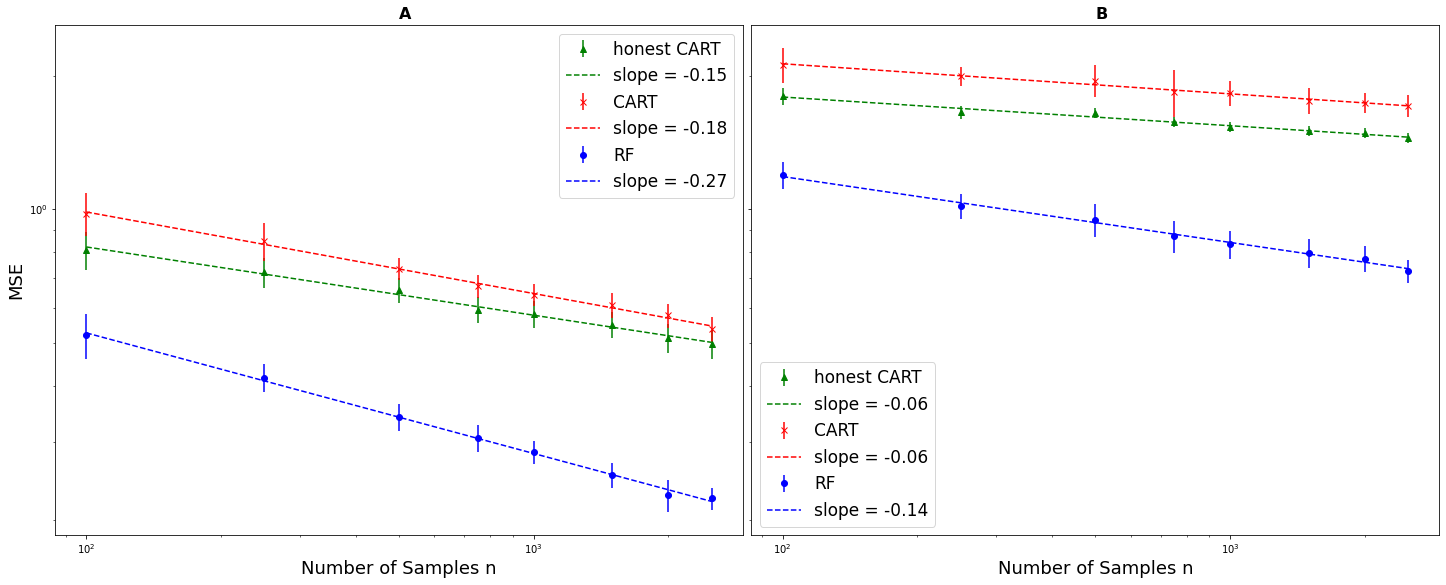

In [367]:
linear_lower_bound_fig,linear_lower_bound_axs = plt.subplots(1,2,figsize = (20,8),sharex = True,sharey = True)


#Plot Performance for different models 

# s = 10
linear_lower_bound_axs[0].errorbar(n_train,honest_CART_scores[0],yerr = honest_CART_error_bar[0],fmt = '^',label = 'honest CART',color = 'green')
linear_lower_bound_axs[0].errorbar(n_train,pow(math.e,honest_CART_best_fit[0][0]*np.array(log_list(n_train))+honest_CART_best_fit[0][1]),linestyle = 'dashed',label = 'slope = ' +str(honest_CART_best_fit[0][0])[:5],color = 'green')

linear_lower_bound_axs[0].errorbar(n_train,CART_scores[0],yerr = CART_error_bar[0],fmt = 'x',label = 'CART',color = 'red')
linear_lower_bound_axs[0].errorbar(n_train,pow(math.e,CART_best_fit[0][0]*np.array(log_list(n_train))+CART_best_fit[0][1]),linestyle = 'dashed',label = 'slope = ' + str(CART_best_fit[0][0])[:5],color = 'red')


linear_lower_bound_axs[0].errorbar(n_train,RF_scores[0],yerr = RF_error_bar[0],fmt = 'o',label = 'RF',color = 'blue')
linear_lower_bound_axs[0].errorbar(n_train,pow(math.e,RF_best_fit[0][0]*np.array(log_list(n_train))+RF_best_fit[0][1]),linestyle = 'dashed',label = 'slope = ' + str(RF_best_fit[0][0])[:5],color = 'blue')



# s = 20 
linear_lower_bound_axs[1].errorbar(n_train,honest_CART_scores[1],yerr = honest_CART_error_bar[0],fmt = '^',label = 'honest CART',color = 'green')
linear_lower_bound_axs[1].errorbar(n_train,pow(math.e,honest_CART_best_fit[1][0]*np.array(log_list(n_train))+honest_CART_best_fit[1][1]),linestyle = 'dashed',label = 'slope = ' +str(honest_CART_best_fit[1][0])[:5],color = 'green')

linear_lower_bound_axs[1].errorbar(n_train,CART_scores[1],yerr = CART_error_bar[1],fmt = 'x',label = 'CART',color = 'red')
linear_lower_bound_axs[1].errorbar(n_train,pow(math.e,CART_best_fit[1][0]*np.array(log_list(n_train))+CART_best_fit[1][1]),linestyle = 'dashed',label = 'slope = ' + str(CART_best_fit[1][0])[:5],color = 'red')


linear_lower_bound_axs[1].errorbar(n_train,RF_scores[1],yerr = RF_error_bar[1],fmt = 'o',label = 'RF',color = 'blue')
linear_lower_bound_axs[1].errorbar(n_train,pow(math.e,RF_best_fit[1][0]*np.array(log_list(n_train))+RF_best_fit[1][1]),linestyle = 'dashed',label = 'slope = ' +str(RF_best_fit[1][0])[:5],color = 'blue')








linear_lower_bound_axs[0].legend(loc = 'best')
linear_lower_bound_axs[1].legend(loc = 'best')

linear_lower_bound_axs[0].text(500.0, 2.85, 'A',
      fontsize=16, fontweight='bold', va='top')
linear_lower_bound_axs[1].text(500.0, 2.85, 'B',
      fontsize=16, fontweight='bold', va='top')
linear_lower_bound_axs[0].set_ylabel('MSE',fontsize = 18)
#linear_lower_bound_axs[1].set_ylabel('MSE',fontsize = 18)

linear_lower_bound_axs[0].set_xlabel('Number of Samples n',fontsize = 18)
linear_lower_bound_axs[1].set_xlabel('Number of Samples n',fontsize = 18)

linear_lower_bound_axs[0].set_yscale('log')
linear_lower_bound_axs[1].set_yscale('log')
linear_lower_bound_axs[0].set_xscale('log')
linear_lower_bound_axs[1].set_xscale('log')

plt.rcParams['legend.fontsize'] = 20


plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.5)


plt.yscale('log')
plt.xscale('log')


In [368]:
linear_lower_bound_fig.savefig('figures/linear_cts.png')